#       SEGUNDO PARCIAL APRENDIZAJE NO SUPERVISADO

Dataset: Leeds Energy Generation Mix (30-minute Time-Series)

Objetivo: Detectar patrones ocultos en la generación de energía mediante clustering, sin usar etiquetas reales (no supervisado).

El archivo part_leeds_energy_mix_V2.csv tiene datos cada 30 minutos con variables que describen:

Fuentes de energía (qué tanta energía se produce de cada tipo):

biomass (biomasa)

coal (carbón)

imports (importaciones)

gas (gas)

nuclear (nuclear)

other (otras)

hydro (hidroeléctrica)

solar (solar)

wind (eólica)


Condiciones meteorológicas:

Air Temperature_GIS (temperatura del aire)

Wind Speed_GIS (velocidad del viento)

Precipitation (Pluvio)_GIS (precipitación)

Relative Humidity_GIS (humedad relativa)

Shortwave Radiation - Incoming_GIS (radiación solar entrante)

Net Radiation_GIS (radiación neta)

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl # Importa la librería principal de matplotlib para graficar.
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples # Importa la función para calcular los coeficientes de silueta para cada punto de datos.
from matplotlib.ticker import FixedLocator, FixedFormatter # Importa herramientas para controlar la ubicación y las etiquetas de los ticks en los gráficos.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
df = pd.read_csv('/content/part_leeds_energy_mix_V2.csv')
df.head()#visualizar las primeras filas

,dateTime_precipitation,value_eccup,value_headingley,value_farnley,value_knostrop,value_heckmondwike,value_bramham,to,forecast_intensity,intensity_index,...,Longwave Radiation - Outgoing_SPN,Atmospheric Pressure_SPN,Precipitation (Pluvio)_SPN,Absolute Humidity_SPN,Relative Humidity_SPN,Net Radiation_SPN,Shortwave Radiation - Incoming_SPN,Air Temperature_SPN,Wind Direction_SPN,Wind Speed_SPN
0,2023-10-26T11:30:00.000000000,0.2,0.4,0.4,0.2,0.02,0.2,2023-10-26T12:00:00.000000000,187.0,moderate,...,366.4,984.3832,0.20,9.189,99.7,59.15,74.67,9.70,119.40396,1.718
1,2023-10-26T12:00:00.000000000,0.2,0.0,0.4,0.0,0.01,0.2,2023-10-26T12:30:00.000000000,174.0,moderate,...,368.1,983.9634,0.00,9.409,99.6,54.55,68.70,10.09,131.45196,1.992
2,2023-10-26T12:30:00.000000000,0.2,0.0,0.2,0.4,0.01,0.0,2023-10-26T13:00:00.000000000,157.0,moderate,...,371.9,983.6172,0.03,9.678,99.5,87.59,109.70,10.55,129.22797,2.396
3,2023-10-26T13:00:00.000000000,0.4,0.6,0.4,0.0,0.00,0.0,2023-10-26T13:30:00.000000000,148.0,moderate,...,372.4,983.3093,0.13,9.755,99.1,77.70,97.60,10.74,136.19848,2.237
4,2023-10-26T13:30:00.000000000,0.0,0.0,0.2,0.0,0.00,0.0,2023-10-26T14:00:00.000000000,157.0,moderate,...,373.6,983.1702,0.00,9.808,98.7,83.26,106.80,10.89,143.56286,2.669


In [63]:
df.info()#35,000 filas (cada 30 minutos, durante varios años)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359089 entries, 0 to 359088
Data columns (total 53 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   dateTime_precipitation              359089 non-null  object 
 1   value_eccup                         356758 non-null  float64
 2   value_headingley                    356758 non-null  float64
 3   value_farnley                       356758 non-null  float64
 4   value_knostrop                      356758 non-null  float64
 5   value_heckmondwike                  356758 non-null  float64
 6   value_bramham                       356758 non-null  float64
 7   to                                  359089 non-null  object 
 8   forecast_intensity                  356758 non-null  float64
 9   intensity_index                     356758 non-null  object 
 10  postcode                            359089 non-null  object 
 11  biomass                   

,value_eccup,value_headingley,value_farnley,value_knostrop,value_heckmondwike,value_bramham,forecast_intensity,biomass,coal,imports,...,Longwave Radiation - Outgoing_SPN,Atmospheric Pressure_SPN,Precipitation (Pluvio)_SPN,Absolute Humidity_SPN,Relative Humidity_SPN,Net Radiation_SPN,Shortwave Radiation - Incoming_SPN,Air Temperature_SPN,Wind Direction_SPN,Wind Speed_SPN
count,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.00000,356758.000000,356758.000000,356758.000000,356758.000000,...,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000,356758.000000
mean,0.055064,0.051179,0.052496,0.045456,0.039277,0.04622,182.449195,28.294416,0.027069,4.870858,...,378.851788,1006.984756,0.043406,8.935118,79.798454,79.401981,149.249275,12.546369,200.668385,2.844007
std,0.284405,0.261833,0.252869,0.253812,0.219322,0.24152,66.938759,10.881959,0.248865,4.522499,...,31.806895,11.219811,0.237539,2.541141,15.130043,154.395771,215.219570,5.347891,98.480763,1.645353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.000000,...,291.800000,971.736600,0.000000,2.531000,30.580000,-87.922000,-6.668000,-3.854000,0.029500,0.246000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,128.000000,21.200000,0.000000,0.600000,...,357.700000,1000.752000,0.000000,7.196000,69.850000,-22.630000,-1.105000,9.000000,127.717030,1.606000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,182.000000,27.900000,0.000000,4.000000,...,377.400000,1008.452000,0.000000,8.759500,82.500000,2.245500,31.755000,12.710000,217.130620,2.502500
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,237.000000,35.000000,0.000000,7.900000,...,398.200000,1014.602000,0.000000,10.692000,92.300000,147.140000,237.800000,16.200000,280.021500,3.779000
max,8.800000,7.600000,6.200000,12.000000,6.130000,7.20000,369.000000,69.700000,5.600000,58.900000,...,488.000000,1030.093000,6.550000,17.761000,101.200000,699.000000,986.000000,28.380000,359.980710,12.840000


In [64]:
print(df.columns.tolist())

['dateTime_precipitation', 'value_eccup', 'value_headingley', 'value_farnley', 'value_knostrop', 'value_heckmondwike', 'value_bramham', 'to', 'forecast_intensity', 'intensity_index', 'postcode', 'biomass', 'coal', 'imports', 'gas', 'nuclear', 'other', 'hydro', 'solar', 'wind', 'Longwave Radiation - Incoming_GIS', 'Longwave Radiation - Outgoing_GIS', 'Atmospheric Pressure_GIS', 'Precipitation (Pluvio)_GIS', 'Absolute Humidity_GIS', 'Relative Humidity_GIS', 'Net Radiation_GIS', 'Shortwave Radiation - Incoming_GIS', 'Air Temperature_GIS', 'Wind Direction_GIS', 'Wind Speed_GIS', 'Longwave Radiation - Incoming_HOL', 'Longwave Radiation - Outgoing_HOL', 'Atmospheric Pressure_HOL', 'Precipitation (Pluvio)_HOL', 'Absolute Humidity_HOL', 'Relative Humidity_HOL', 'Net Radiation_HOL', 'Shortwave Radiation - Incoming_HOL', 'Air Temperature_HOL', 'Wind Direction_HOL', 'Wind Speed_HOL', 'Longwave Radiation - Incoming_SPN', 'Longwave Radiation - Outgoing_SPN', 'Atmospheric Pressure_SPN', 'Precipitati

In [65]:
columnas_usar = [
    'biomass', 'coal', 'imports', 'gas', 'nuclear', 'other',
    'hydro', 'solar', 'wind',
    'Air Temperature_GIS', 'Wind Speed_GIS',
    'Precipitation (Pluvio)_GIS', 'Relative Humidity_GIS',
    'Shortwave Radiation - Incoming_GIS', 'Net Radiation_GIS'
]

In [66]:
df_energia = df[columnas_usar].dropna()#elimina filas con valores faltantes.

In [67]:
print("Total original:", df.shape[0])
print("Después de eliminar nulos:", df[columnas_usar].dropna().shape[0])
print("Usados en el cuadernillo:", df_energia.shape[0])


Total original: 359089
Después de eliminar nulos: 356758
Usados en el cuadernillo: 356758


In [68]:
# 5. Reducir número de ejemplos (para mejorar rendimiento)
df_energia = df_energia.sample(n=3000, random_state=42)#3,000 filas aleatorias

In [69]:
scaler = StandardScaler()#media 0 y desviación estándar 1 (como energía en kWh y temperatura en °C) tienen diferentes escalas.
datos_normalizados = scaler.fit_transform(df_energia)#Ajusta el escalador a los datos y los transforma en una matriz normalizada

In [83]:
# 8. Reducir dimensiones con PCA para acelerar cálculo de silueta
pca = PCA(n_components=5)  #Crea un objeto PCA para reducir las 15 dimensiones originales (9 fuentes de energía + 6 variables meteorológicas) a 6 componentes principales.
datos_reducidos = pca.fit_transform(datos_normalizados)#Ajusta el modelo PCA a los datos normalizados y transforma los datos en un nuevo espacio de 6 dimensiones

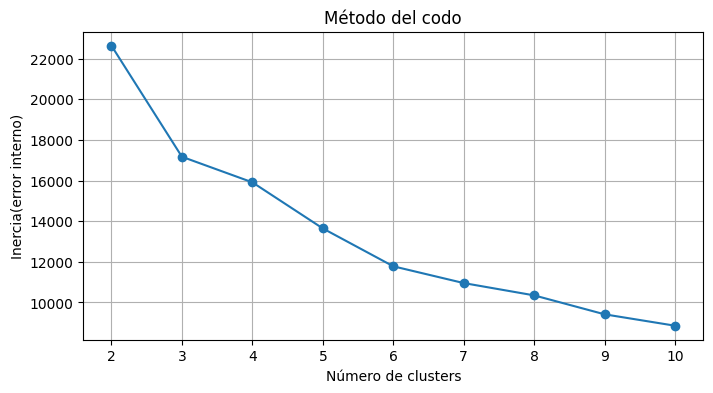

In [84]:
inertias = []# (suma de las distancias al cuadrado de cada
#punto al centroide de su cluster) para diferentes valores de k (número de clusters).

for k in range(2, 11):#prueba valores de k de 2 a 10
    kmeans = KMeans(n_clusters=k, random_state=42)#modelo kmeans con clusters
    kmeans.fit(datos_reducidos)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), inertias, marker='o')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia(error interno)')
plt.grid(True)
plt.show()

In [85]:
# 10. Calcular el Coeficiente de Silueta
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    etiquetas = kmeans.fit_predict(datos_reducidos)
    sil = silhouette_score(datos_reducidos, etiquetas)
    sil_scores.append(sil)
    print(f"Clusters: {k} → Silhouette Score: {sil:.4f}")


Clusters: 2 → Silhouette Score: 0.3385
Clusters: 3 → Silhouette Score: 0.3048
Clusters: 4 → Silhouette Score: 0.2452
Clusters: 5 → Silhouette Score: 0.2543
Clusters: 6 → Silhouette Score: 0.2563
Clusters: 7 → Silhouette Score: 0.2371
Clusters: 8 → Silhouette Score: 0.2164
Clusters: 9 → Silhouette Score: 0.2206
Clusters: 10 → Silhouette Score: 0.2276


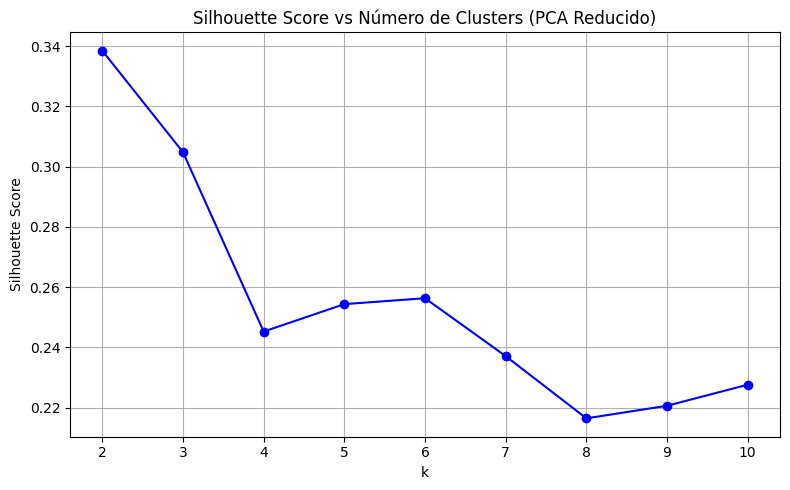

In [86]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', color='blue')
plt.title('Silhouette Score vs Número de Clusters (PCA Reducido)')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

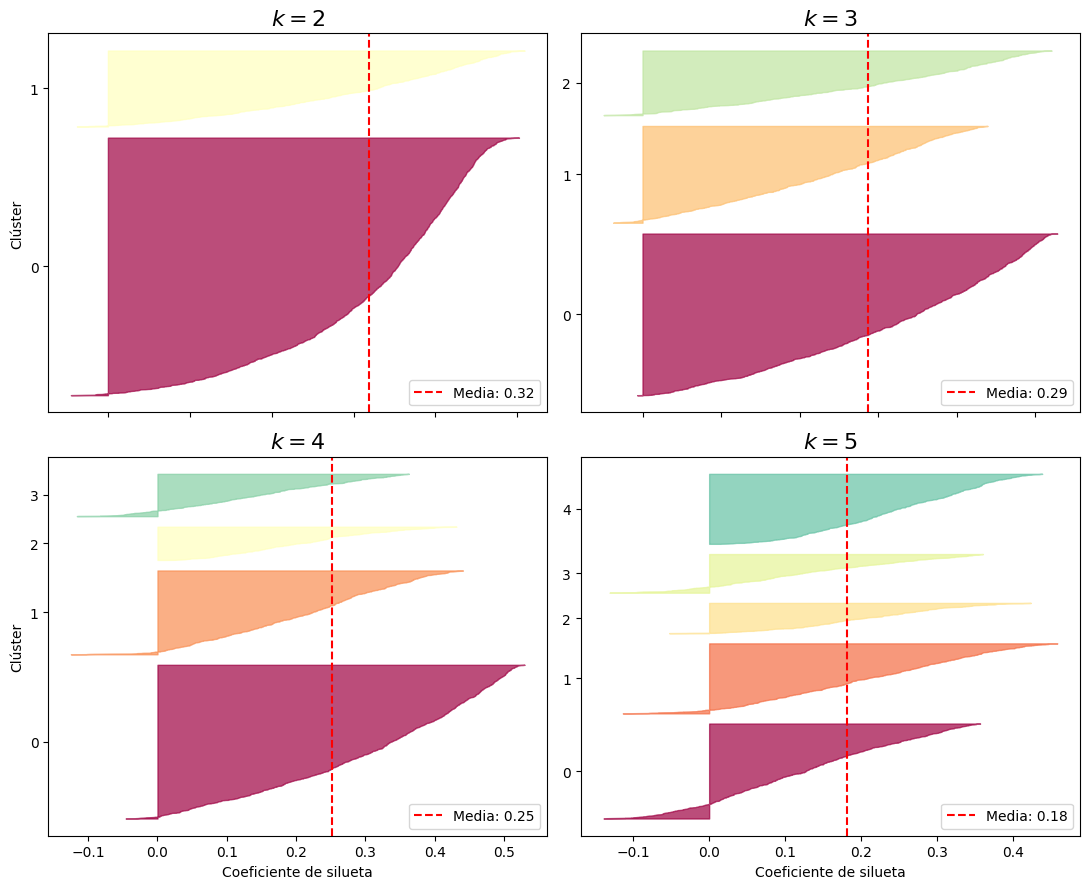

In [74]:
# Definimos valores de k a comparar
valores_k = [2, 3, 4, 5]
modelos_kmeans = []
silhouette_scores = []

# Entrenamos modelos y calculamos silhouette promedio
for k in valores_k:
    modelo = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=512)
    modelo.fit(datos_reducidos)
    modelos_kmeans.append(modelo)
    silhouette_scores.append(silhouette_score(datos_reducidos, modelo.labels_))

# Visualización
plt.figure(figsize=(11, 9))

for idx, k in enumerate(valores_k):
    plt.subplot(2, 2, idx + 1)

    y_pred = modelos_kmeans[idx].labels_
    silhouette_coeffs = silhouette_samples(datos_reducidos, y_pred)

    padding = len(datos_reducidos) // 30
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    if idx in (0, 2):
        plt.ylabel("Clúster")
    if idx in (2, 3):
        plt.xlabel("Coeficiente de silueta")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--", label=f"Media: {silhouette_scores[idx]:.2f}")
    plt.title(f"$k={k}$", fontsize=16)
    plt.legend()

plt.tight_layout()
plt.show()

In [75]:
# 11. Aplicar KMeans con número óptimo de clusters (por ejemplo k=4)
kmeans_final = KMeans(n_clusters=4, random_state=42)
df_energia['Cluster'] = kmeans_final.fit_predict(datos_reducidos)

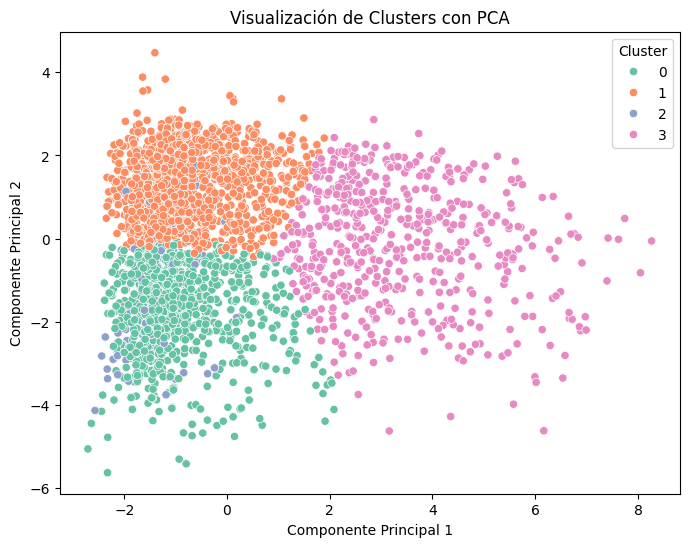

In [76]:
# 12. Visualizar los clusters (PCA con 2 componentes)
pca_vis = PCA(n_components=2)
datos_vis = pca_vis.fit_transform(datos_normalizados)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=datos_vis[:, 0], y=datos_vis[:, 1], hue=df_energia['Cluster'], palette='Set2')
plt.title('Visualización de Clusters con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [77]:
# 13. Analizar los centroides
centroides = pd.DataFrame(kmeans_final.cluster_centers_, columns=[f'PC{i+1}' for i in range(6)])
centroides

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.941465,-1.754724,0.167685,-0.180886,-0.002021,-0.271021
1,-0.744339,1.324685,-0.006887,0.001937,-0.063637,-0.066564
2,-1.449689,-1.605724,-1.625380,3.000193,1.451791,2.850239
3,3.345734,-0.118521,-0.018470,-0.138569,-0.050495,0.176962


In [78]:
# 14. Agregar resultados al dataframe original
df_resultado = df.copy()
df_resultado = df_resultado.loc[df_energia.index]
df_resultado['Cluster'] = df_energia['Cluster']
df_resultado.head()

,dateTime_precipitation,value_eccup,value_headingley,value_farnley,value_knostrop,value_heckmondwike,value_bramham,to,forecast_intensity,intensity_index,...,Atmospheric Pressure_SPN,Precipitation (Pluvio)_SPN,Absolute Humidity_SPN,Relative Humidity_SPN,Net Radiation_SPN,Shortwave Radiation - Incoming_SPN,Air Temperature_SPN,Wind Direction_SPN,Wind Speed_SPN,Cluster
290737,2023-04-03T11:30:00.000000000,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-03T12:00:00.000000000,170.0,moderate,...,1025.4270,0.0,5.265,64.79,320.000,520.800,7.737,141.90458,4.313,3
58671,2023-09-27T18:30:00.000000000,0.0,0.0,0.0,0.0,0.0,0.0,2023-09-27T19:00:00.000000000,97.0,low,...,995.6145,0.0,12.061,80.40,-32.851,-1.555,17.610,148.90857,8.580,0
163884,2023-07-13T17:00:00.000000000,0.0,0.0,0.0,0.0,0.0,0.0,2023-07-13T17:30:00.000000000,236.0,high,...,1007.2700,0.0,9.405,54.59,237.000,409.300,19.950,281.18155,3.380,3
28614,2023-10-01T14:00:00.000000000,0.0,0.0,0.0,0.0,0.0,0.0,2023-10-01T14:30:00.000000000,117.0,low,...,1010.2350,0.0,14.128,84.50,77.770,112.400,19.440,209.07424,2.337,0
168031,2023-07-02T02:30:00.000000000,0.0,0.0,0.2,0.0,0.0,0.0,2023-07-02T03:00:00.000000000,85.0,low,...,1000.7550,0.0,8.183,73.18,-81.741,-3.491,12.780,269.02919,4.623,0
